# 📓 Notebook – Pipeline de alineamiento de tRNA-Sec

## 📝 Chunk 1 – Configuración de entorno y rutas

In [1]:
import os
import pandas as pd
import subprocess
import re
import Bio.SeqIO as SeqIO
from Bio import Phylo
from collections import Counter
import logomaker
import matplotlib.pyplot as plt
import ViennaRNA as RNA

# Archivos de entrada
input_file = "../data/raw/200_trna_sec.csv"

# Archivos en Windows
fasta_windows   = r"C:\Users\ro-ma\tRNA_sequences.fasta"
sto_windows     = r"C:\Users\ro-ma\tRNA_sequences.sto"
aligned_windows = r"C:\Users\ro-ma\tRNA_alignment.fasta"
tree_file = r"C:\Users\ro-ma\tRNA_phylogenetic_tree.nhx"

# Equivalentes en WSL
fasta_wsl   = "/mnt/c/Users/ro-ma/tRNA_sequences.fasta"
sto_wsl     = "/mnt/c/Users/ro-ma/tRNA_sequences.sto"
aligned_wsl = "/mnt/c/Users/ro-ma/tRNA_alignment.fasta"

# Ejecutables externos
cmalign_bin      = "/usr/bin/cmalign"
esl_reformat_bin = "/home/ro-ma/infernal_models/infernal/easel/miniapps/esl-reformat"
cm_model         = "/home/ro-ma/infernal_models/infernal/RF01852.cm"
fasttree_exe     = r"C:\Program Files\FastTree\FastTree.exe"


In [2]:
# =====================================================
# 1. Convertir CSV a FASTA
# =====================================================
def convert_csv_to_fasta(csv_path, fasta_path, mapping_file="id_mapping.csv"):
    """
    Convierte CSV a FASTA:
    - Extrae un nombre taxonómico lo más informativo posible.
    - Reemplaza espacios/caracteres raros por '_' para que FastTree no los corte.
    - Guarda también un mapping CSV para recuperar los nombres originales.
    """
    try:
        import pandas as pd, re
        df = pd.read_csv(csv_path)
        mapping = []

        with open(fasta_path, "w") as fasta_file:
            for _, row in df.iterrows():
                urs_id = str(row['URS_ID']).strip()
                description = str(row['description']).strip()

                # Intentar extraer nombre binomial o Candidatus
                species_name = None
                match_binomial = re.search(r'([A-Z][a-z]+ [a-z]+)', description)
                if match_binomial:
                    species_name = match_binomial.group(1)

                match_candidatus = re.search(r'([A-Z][a-z]+ [A-Z][a-z]+(?: [a-z]+)?)', description)
                if match_candidatus:
                    species_name = match_candidatus.group(1)

                if not species_name:
                    species_name = description

                safe_species = re.sub(r"[^A-Za-z0-9_.-]", "_", species_name)
                header = f">{urs_id}|{safe_species}|{description}"
                sequence = str(row['Sequence']).strip()
                fasta_file.write(f"{header}\n{sequence}\n")

                mapping.append([urs_id, safe_species, description])

        pd.DataFrame(mapping, columns=["URS_ID", "safe_species", "description"]).to_csv(mapping_file, index=False)

        print(f"✅ Archivo FASTA creado en (Windows): {fasta_path}")
        print(f"✅ Mapping de nombres guardado en: {mapping_file}")

    except Exception as e:
        print(f"❌ Error al convertir a FASTA: {e}")


# =====================================================
# 2. Alineamiento (cmalign + esl-reformat + preview)
# =====================================================
def run_cmalign(fasta_wsl, sto_windows, cmalign_bin, cm_model):
    """Ejecuta cmalign desde WSL"""
    import subprocess
    print("⏳ Ejecutando cmalign desde WSL...")
    try:
        with open(sto_windows, "w") as sto_out:
            subprocess.run(["wsl", cmalign_bin, cm_model, fasta_wsl],
                           stdout=sto_out, check=True)
        print(f"✅ Archivo Stockholm generado en: {sto_windows}")
    except subprocess.CalledProcessError as e:
        print("❌ Error ejecutando cmalign:", e)


def run_esl_reformat(sto_wsl, aligned_windows, esl_reformat_bin):
    """Ejecuta esl-reformat para convertir Stockholm a FASTA alineado"""
    import subprocess
    print("⏳ Ejecutando esl-reformat desde WSL...")
    try:
        with open(aligned_windows, "w") as fasta_out:
            subprocess.run(["wsl", esl_reformat_bin, "afa", sto_wsl],
                           stdout=fasta_out, check=True)
        print(f"✅ Alineamiento FASTA generado en: {aligned_windows}")
    except subprocess.CalledProcessError as e:
        print("❌ Error ejecutando esl-reformat:", e)


def preview_alignment(aligned_windows, n=20):
    """Muestra las primeras líneas del alineamiento"""
    import os
    if os.path.exists(aligned_windows):
        print("\n📖 Vista previa del alineamiento:")
        with open(aligned_windows, "r") as f:
            for line in f.readlines()[:n]:
                print(line.strip())
    else:
        print("⚠️ No existe el archivo de alineamiento.")

def run_alignment_pipeline(fasta_wsl, sto_windows, sto_wsl, aligned_windows,
                           cmalign_bin, cm_model, esl_reformat_bin, preview_lines=20):
    """Pipeline completo: cmalign + esl-reformat + vista previa"""
    run_cmalign(fasta_wsl, sto_windows, cmalign_bin, cm_model)
    run_esl_reformat(sto_wsl, aligned_windows, esl_reformat_bin)
    preview_alignment(aligned_windows, n=preview_lines)

# =====================================================
# 3. Construcción del Árbol con FastTree
# =====================================================
def build_phylogenetic_tree(input_alignment, output_tree, fasttree_exe):
    """Construye árbol filogenético con FastTree."""
    import os, subprocess
    if not os.path.exists(input_alignment):
        print(f"❌ Error: no existe alineamiento '{input_alignment}'.")
        return

    print("⏳ Construyendo árbol filogenético con FastTree...")
    try:
        with open(output_tree, "w") as out_tree:
            subprocess.run(
                [fasttree_exe, "-nt", input_alignment],
                stdout=out_tree,
                check=True
            )
        print(f"✅ Árbol guardado en: {output_tree}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error ejecutando FastTree: {e}")


# =====================================================
# 4. Visualización radial única
# =====================================================
def visualize_tree_radial(tree_file, out_image="tree_radial.png"):
    """Visualiza el árbol en formato radial con ete3."""
    import os
    from ete3 import Tree, TreeStyle
    from IPython.display import Image, display

    if not os.path.exists(tree_file):
        print(f"❌ Error: no existe árbol '{tree_file}'.")
        return

    print("📊 Visualizando árbol filogenético en formato radial...")
    t = Tree(tree_file)

    ts = TreeStyle()
    ts.mode = "c"       # circular
    ts.show_leaf_name = True
    ts.show_branch_support = True
    ts.scale = 50

    t.render(out_image, tree_style=ts, w=2000, units="px")
    print(f"✅ Imagen radial del árbol guardada en: {out_image}")
    display(Image(filename=out_image))


# =====================================================
# 5. Interpretación automática del Árbol
# =====================================================
def find_maximal_clades(clades):
    """
    Dado un conjunto de clados, elimina los que están contenidos en otros clados más grandes.
    """
    maximal = []
    for clade in clades:
        contained = False
        for other in clades:
            if clade is not other and set(clade.get_terminals()).issubset(set(other.get_terminals())):
                contained = True
                break
        if not contained:
            maximal.append(clade)
    return maximal


def interpret_tree_markdown(tree_file, min_clade_size=4, support_cutoff=0.7, report_file="tree_report.md"):
    """
    Interpreta un árbol filogenético y genera un informe Markdown.
    
    - min_clade_size: número mínimo de secuencias para considerar un clado.
    - support_cutoff: bootstrap mínimo para reportar un clado.
    """
    if not os.path.exists(tree_file):
        print(f"❌ Error: No existe {tree_file}")
        return
    
    tree = Phylo.read(tree_file, "newick")
    leaves = tree.get_terminals()
    n_total = len(leaves)

    report = []
    report.append(f"# 📖 Interpretación automática del árbol filogenético\n")
    report.append(f"- Número total de secuencias: **{n_total}**\n")
    
    # --- Conteo global de especies
    species = [str(leaf).split("|")[1].strip() for leaf in leaves if "|" in str(leaf)]
    sp_counts = Counter(species)
    report.append("## 🧾 Especies más frecuentes\n")
    for sp, c in sp_counts.most_common(10):
        report.append(f"- {sp}: {c} secuencias")

    # --- Pre-filtrar y encontrar clados maximales
    valid_clades = []
    for clade in tree.get_nonterminals():
        if hasattr(clade, "confidence") and clade.confidence is not None and clade.confidence < support_cutoff:
            continue
        sub_leaves = clade.get_terminals()
        if len(sub_leaves) < min_clade_size or len(sub_leaves) == n_total:
            continue
        valid_clades.append(clade)
    
    maximal_clades = find_maximal_clades(valid_clades)

    # --- Reportar clados monoespecíficos
    report.append("\n## 🌱 Clados monoespecíficos grandes\n")
    found_mono = False
    for clade in maximal_clades:
        sub_species = [str(leaf).split("|")[1].strip() for leaf in clade.get_terminals() if "|" in str(leaf)]
        sp_counts = Counter(sub_species)

        if len(sp_counts) == 1:  # solo una especie
            sp = list(sp_counts.keys())[0]
            confidence_str = f"{clade.confidence:.2f}" if clade.confidence is not None else "N/A"
            report.append(f"- {sp}: {len(clade.get_terminals())} secuencias (bootstrap={confidence_str})")
            ejemplos = [str(x) for x in clade.get_terminals()[:3]]
            report.append(f"  - Ejemplos: {ejemplos}")
            found_mono = True
    if not found_mono:
        report.append("No se encontraron clados monoespecíficos que cumplan los criterios.")

    # --- Reportar clados mixtos
    report.append("\n## 🔀 Clados mixtos interesantes\n")
    found_mixed = False
    for clade in maximal_clades:
        sub_species = [str(leaf).split("|")[1].strip() for leaf in clade.get_terminals() if "|" in str(leaf)]
        sp_counts = Counter(sub_species)

        if len(sp_counts) > 1:
            confidence_str = f"{clade.confidence:.2f}" if clade.confidence is not None else "N/A"
            report.append(f"- Clado con {len(clade.get_terminals())} secuencias y {len(sp_counts)} especies (bootstrap={confidence_str})")
            for sp, c in sp_counts.most_common(3):
                report.append(f"  - {sp}: {c} secuencias")
            ejemplos = [str(x) for x in clade.get_terminals()[:3]]
            report.append(f"  - Ejemplos: {ejemplos}")
            found_mixed = True
    if not found_mixed:
        report.append("No se encontraron clados mixtos que cumplan los criterios.")

    # --- Secuencias divergentes
    report.append("\n## 🌍 Secuencias divergentes / posibles outgroups\n")
    long_branches = sorted([(leaf, leaf.branch_length) for leaf in leaves if leaf.branch_length],
                             key=lambda x: x[1], reverse=True)[:10]
    for leaf, length in long_branches:
        report.append(f"- {leaf} (rama larga: {length:.3f})")

    # --- Guardar a archivo
    with open(report_file, "w", encoding="utf-8") as f:
        f.write("\n".join(report))

    print(f"✅ Informe generado en: {report_file}")

# =====================================================
# 6. Generación de Sequence Logo para interpretar el alineamiento
# =====================================================

def generate_sequence_logo(alignment_fasta, out_logo="tRNA_logo_filtered.png", gap_threshold=0.9):
    """
    Genera un sequence logo a partir de un alineamiento (FASTA).
    - alignment_fasta: archivo FASTA alineado por Infernal (ya incluye gaps '-')
    - out_logo: ruta de salida del PNG
    - gap_threshold: descarta columnas con >90% gaps
    """
    if not os.path.exists(alignment_fasta):
        print(f"❌ Error: no existe alineamiento {alignment_fasta}")
        return

    # --- leer alineamiento directamente ---
    seqs = [str(record.seq) for record in SeqIO.parse(alignment_fasta, "fasta")]
    df = pd.DataFrame([list(seq) for seq in seqs])

    # --- filtrar columnas con demasiados gaps ---
    gap_fraction = (df == "-").sum() / len(df)
    df = df.loc[:, gap_fraction < gap_threshold]
    df.replace("-", pd.NA, inplace=True)

    # --- matriz de frecuencias ---
    freq_matrix = pd.DataFrame(
        {i: df[i].value_counts(normalize=True) for i in df.columns}
    ).fillna(0).T

    # --- crear logo ---
    num_positions = freq_matrix.shape[0]
    width = max(10, num_positions * 0.2)
    height = 6
    fig, ax = plt.subplots(figsize=(width, height))

    logo = logomaker.Logo(
        freq_matrix,
        ax=ax,
        shade_below=.5,
        fade_below=.5,
        color_scheme="classic"
    )
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    logo.style_xticks(rotation=90)
    logo.ax.set_ylabel('Frecuencia')

    plt.savefig(out_logo, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ Sequence logo guardado en: {out_logo}")

# =====================================================
# 7. Visualización de estructuras secundarias por especie (ViennaRNA + URS ID)
# =====================================================
def plot_rna_by_species(fasta_file, out_dir="rna_plots_by_species", max_per_fig=12):
    """
    Genera figuras con estructuras secundarias predichas (ViennaRNA) agrupadas por especie.
    Cada imagen muestra el URS ID + MFE.
    """
    import os
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from Bio import SeqIO
    import ViennaRNA as RNA
    import re

    os.makedirs(out_dir, exist_ok=True)

    # 📚 Leer secuencias y agrupar por especie
    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    species_groups = {}
    for record in sequences:
        parts = record.id.split('|')

        # Extraer binomial válido (ej: Homo sapiens, Escherichia coli)
        description = " ".join(parts[1:]) if len(parts) > 1 else record.id
        match_binomial = re.search(r"([A-Z][a-z]+ [a-z]+)", description)
        if match_binomial:
            species_name = match_binomial.group(1)
        else:
            species_name = parts[1] if len(parts) > 1 else record.id

        safe_species = species_name.replace(" ", "_")
        species_groups.setdefault(safe_species, {"name": species_name, "records": []})
        species_groups[safe_species]["records"].append(record)

    print(f"📥 {len(sequences)} secuencias cargadas, agrupadas por {len(species_groups)} especies.")

    # 📈 Iterar sobre especies
    for species_id, info in species_groups.items():
        species_name = info["name"]
        group = info["records"]
        print(f"\nGenerando figuras para la especie: {species_name} ({len(group)} secuencias)")

        for i in range(0, len(group), max_per_fig):
            block = group[i:i+max_per_fig]
            fig, axes = plt.subplots(3, 4, figsize=(18, 14))
            axes = axes.flatten()

            for j, record in enumerate(block):
                seq = str(record.seq).replace("T", "U")
                if not seq:
                    continue

                # 🔬 Predicción secundaria con ViennaRNA
                ss, mfe = RNA.fold(seq)

                # Guardar estructura como SVG/PNG
                safe_id = record.id.replace('|', '_').replace(" ", "_")
                svg_file = os.path.join(out_dir, f"{safe_id}.svg")
                RNA.svg_rna_plot(seq, ss, svg_file)

                png_file = svg_file.replace(".svg", ".png")
                try:
                    import cairosvg
                    cairosvg.svg2png(url=svg_file, write_to=png_file)
                except ImportError:
                    png_file = None

                # Extraer URS ID (primer campo del header)
                urs_id = record.id.split('|')[0]

                # 🖼️ Mostrar imagen en subplot
                ax = axes[j]
                if png_file and os.path.exists(png_file):
                    img = mpimg.imread(png_file)
                    ax.imshow(img)

                ax.set_title(f"{urs_id}\nMFE={mfe:.2f}", fontsize=9)
                ax.axis("off")

            # Ocultar ejes vacíos
            for k in range(len(block), len(axes)):
                axes[k].axis("off")

            # Guardar figura final
            fig.suptitle(f"Estructuras de ARN — {species_name}", fontsize=16)
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])

            output_fig_path = os.path.join(out_dir, f"rna_structures_{species_id}_{i//max_per_fig+1}.png")
            fig.savefig(output_fig_path, dpi=300)
            plt.close(fig)

            print(f"✅ Figura guardada: {output_fig_path}")


✅ Archivo FASTA creado en (Windows): C:\Users\ro-ma\tRNA_sequences.fasta
✅ Mapping de nombres guardado en: id_mapping.csv
⏳ Ejecutando cmalign desde WSL...
✅ Archivo Stockholm generado en: C:\Users\ro-ma\tRNA_sequences.sto
⏳ Ejecutando esl-reformat desde WSL...
✅ Alineamiento FASTA generado en: C:\Users\ro-ma\tRNA_alignment.fasta

📖 Vista previa del alineamiento:
>URS00001DA281_9606|Homo_sapiens|Homo sapiens (human) tRNA-SeC (anticodon TCA) 1-1 (TRU-TCA1-1)
......GCCCGGAUG.....AUCCU.C.A.GUGGU.........................
....CUGGGGUGCAGGCUUCAA.A..............................CCUGU.
A.GCUGUCUAGC--....--...........GACAGA..-GUGGUUCAAUU.........
..................CCAC............CUUU.CGG...G.Cg...........
>URS0000C8E9EB_9606|Homo_sapiens|Homo sapiens (human) tRNA-SeC (anticodon TCA) 2-1 (TRU-TCA2-1)
......GCUCGGAUG.....AUCCU.C.A.GUGGU.........................
....CUGGGGUGCAGGCUUCAA.A..............................CCUGU.
A.GCUGUCUAGU--....--...........GACAGA..-GUGGUUCAAUU.........
...............

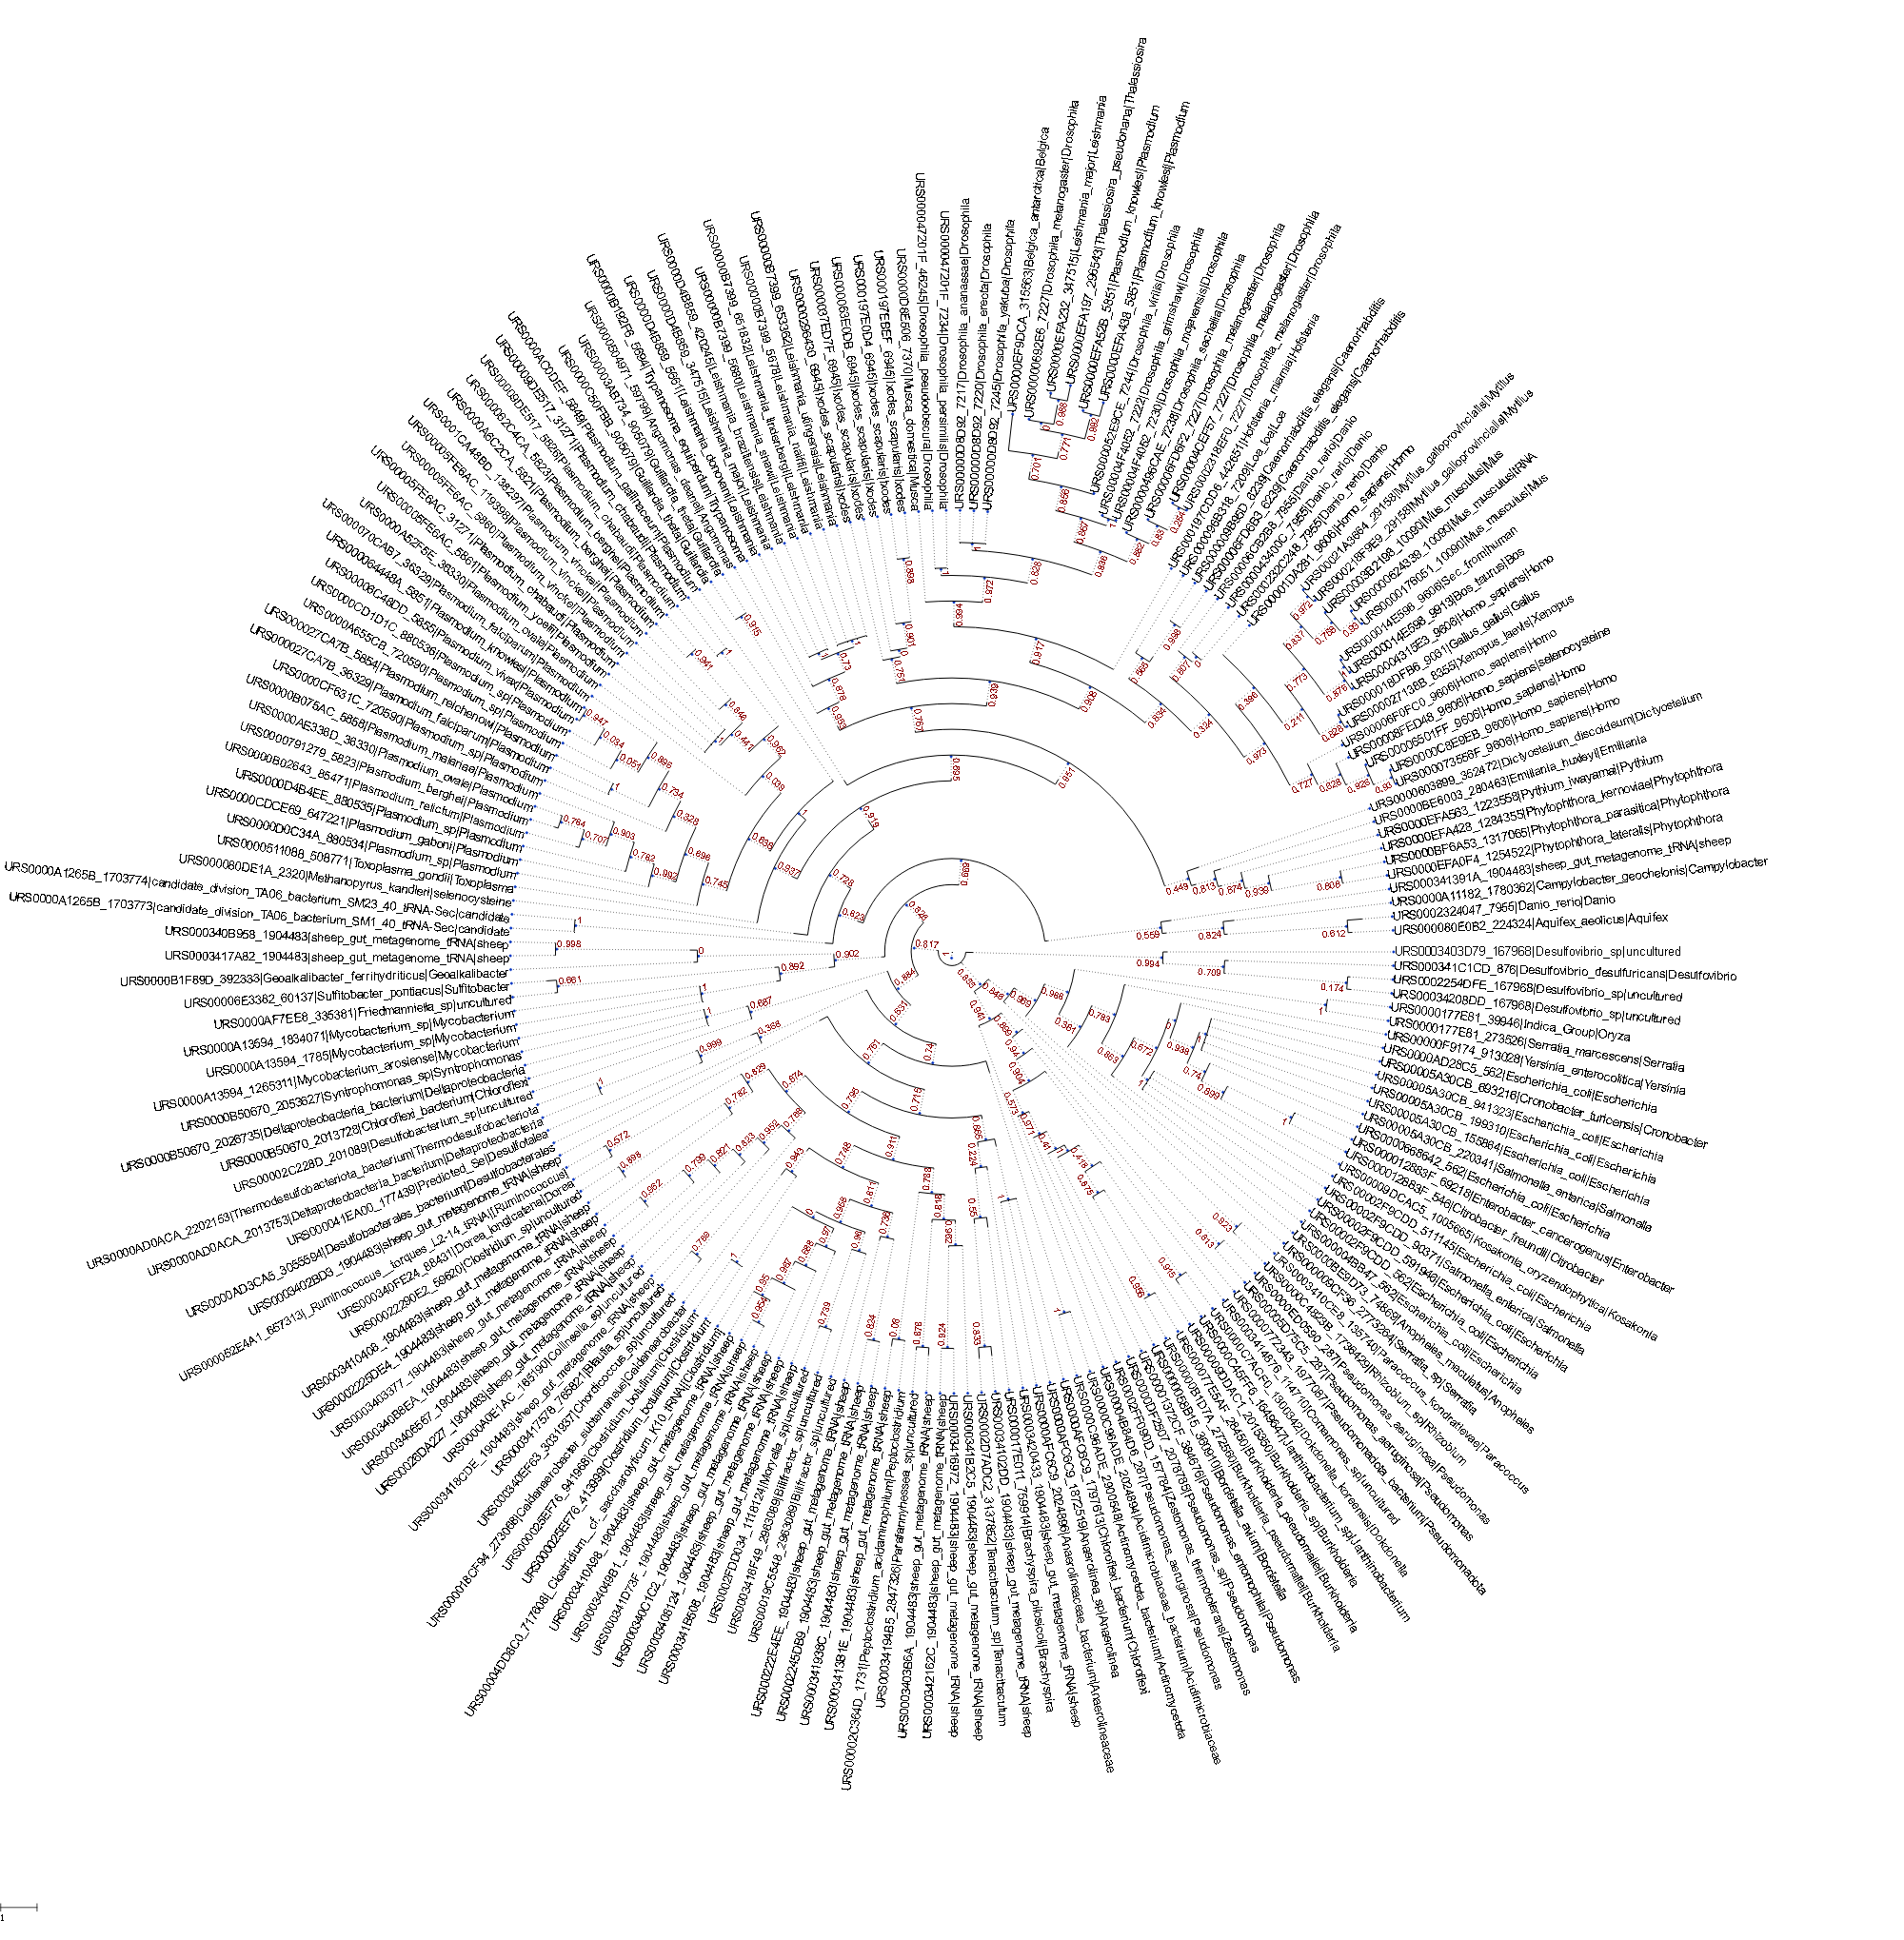

✅ Informe generado en: tree_report.md


c:\Users\ro-ma\anaconda3\Lib\site-packages\logomaker\src\error_handling.py:58: UserWarning:  Warning: Character '.' is not in color_dict. Using black.
  warnings.warn(str(Error))
c:\Users\ro-ma\anaconda3\Lib\site-packages\logomaker\src\error_handling.py:58: UserWarning:  Warning: Character 'N' is not in color_dict. Using black.
  warnings.warn(str(Error))


✅ Sequence logo guardado en: ../data/processed/tRNA_logo_filtered.png
📥 200 secuencias cargadas, agrupadas por 118 especies.

Generando figuras para la especie: Homo_sapiens (7 secuencias)
✅ Figura guardada: ../data/processed/rna_plots_by_species\rna_structures_Homo_sapiens_1.png

Generando figuras para la especie: Sec_from (1 secuencias)
✅ Figura guardada: ../data/processed/rna_plots_by_species\rna_structures_Sec_from_1.png

Generando figuras para la especie: Mus_musculus (3 secuencias)
✅ Figura guardada: ../data/processed/rna_plots_by_species\rna_structures_Mus_musculus_1.png

Generando figuras para la especie: Caenorhabditis_elegans (2 secuencias)
✅ Figura guardada: ../data/processed/rna_plots_by_species\rna_structures_Caenorhabditis_elegans_1.png

Generando figuras para la especie: Drosophila_melanogaster (4 secuencias)
✅ Figura guardada: ../data/processed/rna_plots_by_species\rna_structures_Drosophila_melanogaster_1.png

Generando figuras para la especie: Danio_rerio (4 secuencias

KeyboardInterrupt: 

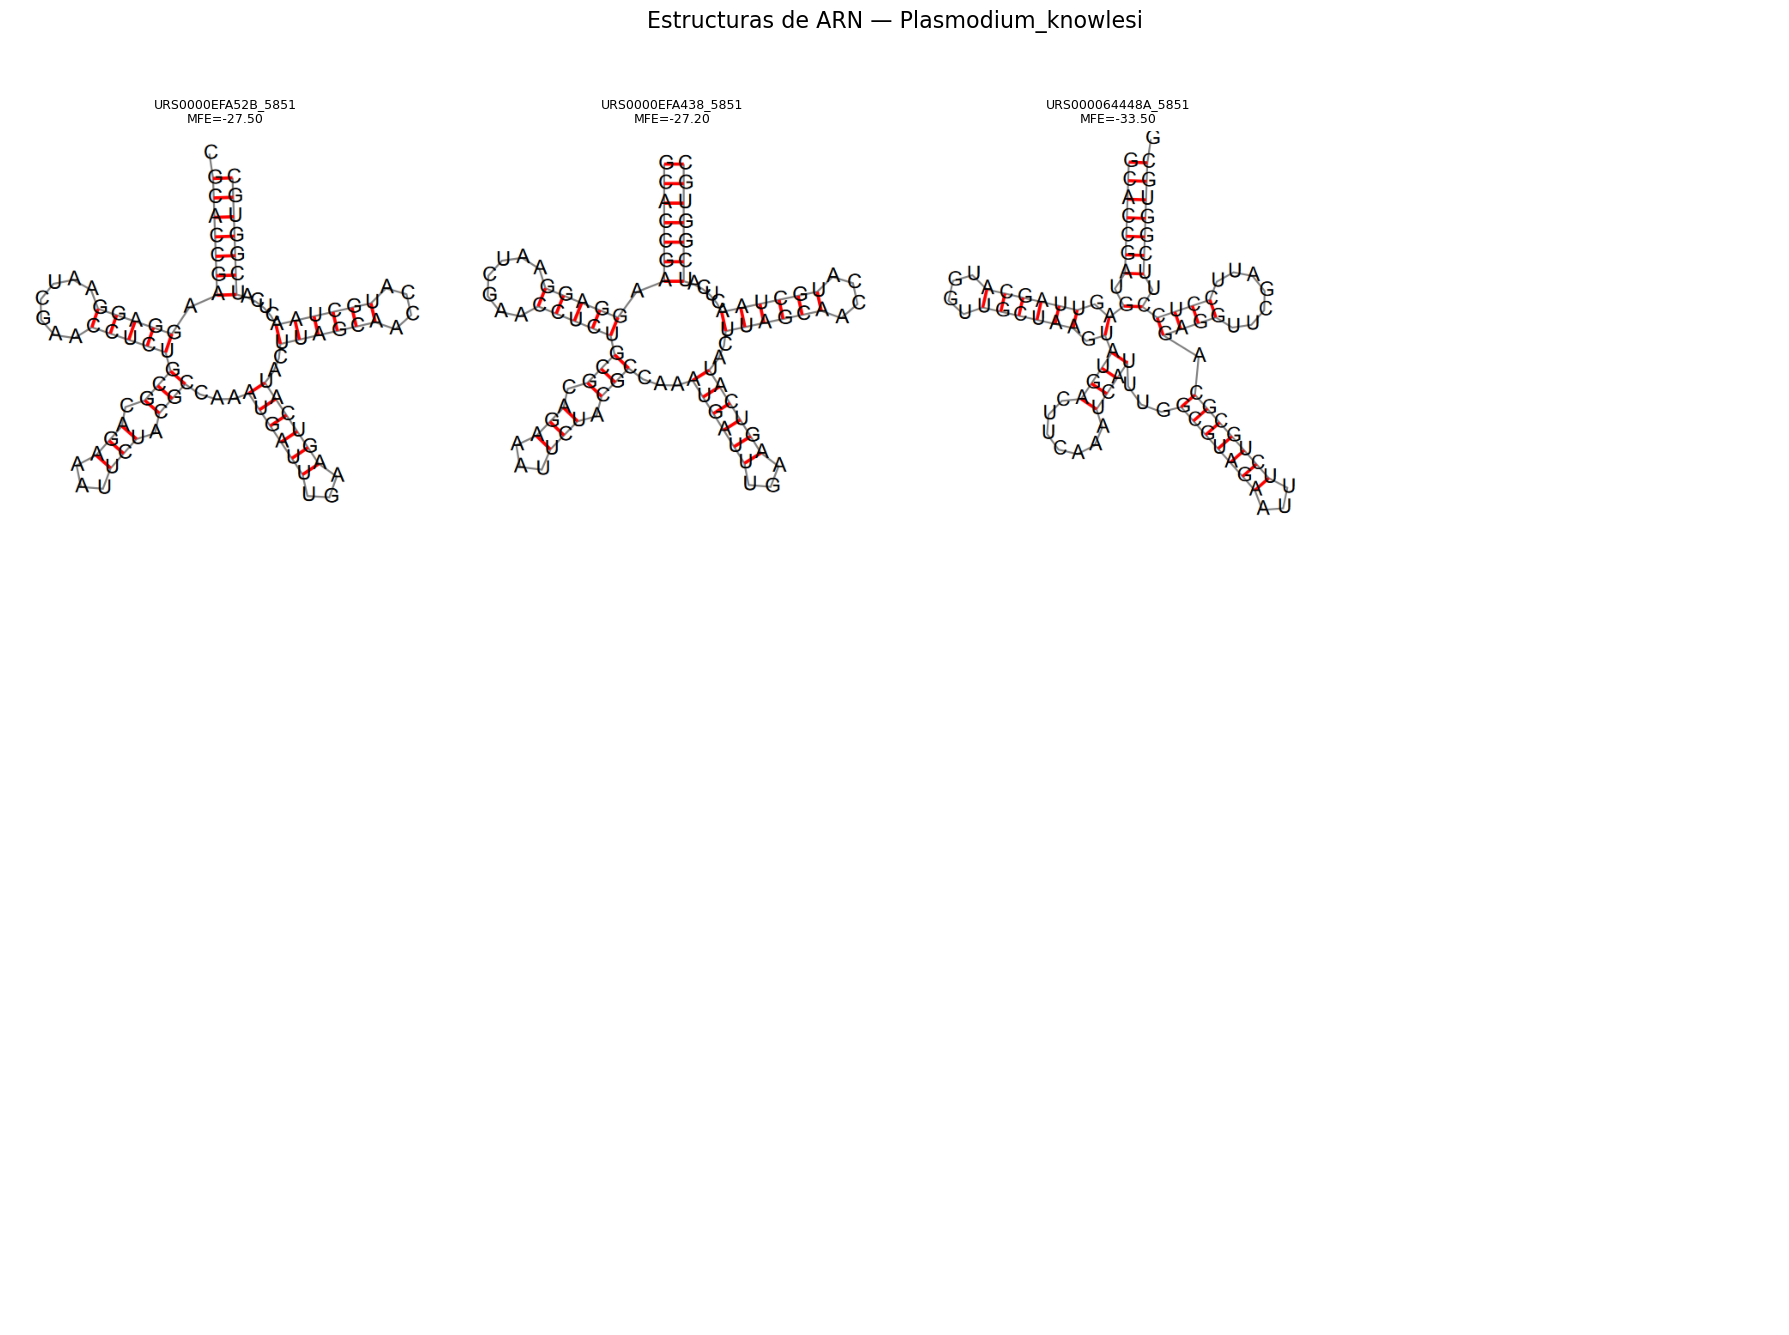

In [3]:
# =====================================================
# 🚀 Flujo principal
# =====================================================
if __name__ == "__main__":

    # 1. Convertir CSV → FASTA
    convert_csv_to_fasta(input_file, fasta_windows)

    # 2. Pipeline completo: cmalign + esl-reformat + preview
    run_alignment_pipeline(
        fasta_wsl=fasta_wsl,
        sto_windows=sto_windows,
        sto_wsl=sto_wsl,
        aligned_windows=aligned_windows,
        cmalign_bin=cmalign_bin,
        cm_model=cm_model,
        esl_reformat_bin=esl_reformat_bin,
        preview_lines=20)
    # 3. Construir árbol
    build_phylogenetic_tree(aligned_windows, tree_file, fasttree_exe)

    # 4. Visualizar radial
    visualize_tree_radial(tree_file, out_image="tree_radial.png")

    # 5. Interpretar árbol
    interpret_tree_markdown(tree_file, report_file="tree_report.md")

    # 6. Generar sequence logo
    generate_sequence_logo(aligned_windows, out_logo="../data/processed/tRNA_logo_filtered.png")

    # 7. Visualizar estructuras secundarias agrupadas por especie
    plot_rna_by_species(
        fasta_windows, 
        out_dir="../data/processed/rna_plots_by_species",
        max_per_fig=12
                        )


    

